In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio

overlap_thresholds = [0.1, 0.2, 0.5]

test_s_ids = [
    "01-05-0024", "01-05-0020", "01-04-0013", "01-03-0033", "01-03-0023", "01-04-0008", "01-04-0029", "01-05-0002",
    "01-04-0015", "01-04-0007", "01-03-0003", "01-02-0006", "01-05-0018", "01-03-0059", "01-03-0040", "01-03-0004",
    "01-04-0016", "01-02-0010", "01-03-0060", "01-03-0026", "01-01-0023", "01-03-0062", "01-01-0046", "01-01-0048",
    "01-03-0051", "01-03-0012", "01-01-0044", "01-03-0064", "01-01-0043", "01-01-0029", "01-03-0027", "01-01-0028",
    "01-03-0031", "01-03-0014", "01-01-0049", "01-01-0004"
]

# shared functions

In [2]:
def merge_and_filter_spindles(spindles, merge_dur=0.3, merge_dist=0.1, min_dur=0.3, max_dur=2.5):
    sort_idx = np.argsort(spindles[:, 0])
    spindles = spindles[sort_idx]
    durations = spindles[:, 1] - spindles[:, 0]
    distances = spindles[1:, 0] - spindles[:-1, 1]
    to_merge = (durations[:-1] < merge_dur) & (durations[1:] < merge_dur) & (distances < merge_dist)
    spindles[np.r_[to_merge, False], 1] = spindles[np.r_[False, to_merge], 1]
    spindles = spindles[~np.r_[False, to_merge]]

    durations = spindles[:, 1] - spindles[:, 0]
    to_filter = (durations < min_dur) | (durations > max_dur)
    spindles = spindles[~to_filter]

    print(f'Merged {np.sum(to_merge)} spindles, filtered {np.sum(to_filter)} spindles')

    return spindles


def calc_tp_fp_fn(gt_spindles, pred_spindles, spindle_thresholds):
    # make sure spindles are sorted
    gt_spindles = gt_spindles[np.argsort(gt_spindles[:, 0])]
    pred_spindles = pred_spindles[np.argsort(pred_spindles[:, 0])]
    tp, fp = [0] * len(spindle_thresholds), [0] * len(spindle_thresholds)

    used_spindles = [np.zeros(len(gt_spindles)) for _ in range(len(spindle_thresholds))]
    gt_start = 0
    for pred_s in pred_spindles:
        intersects = [0] * len(gt_spindles)
        unions = [0] * len(gt_spindles)
        for gt_i in range(gt_start, len(gt_spindles)):
            gt_s = gt_spindles[gt_i]
            if pred_s[1] < gt_s[0]:
                break
            if pred_s[0] > gt_s[1]:
                gt_start = gt_i + 1
                continue
            intersects[gt_i] = min(gt_s[1], pred_s[1]) - max(gt_s[0], pred_s[0])
            unions[gt_i] = max(gt_s[1], pred_s[1]) - min(gt_s[0], pred_s[0])
        ious = [intersects[i] / unions[i] if unions[i] > 0 else 0
                for i in range(len(intersects))]
        for i, spindle_threshold in enumerate(spindle_thresholds):
            if len(ious) > 0 and max(ious) > spindle_threshold:
                tp[i] += 1
                used_spindles[i][np.argmax(ious)] = 1
            else:
                fp[i] += 1

    fn = [len(gt_spindles) - np.sum(used_spindles[i]) for i in range(len(spindle_thresholds))]

    return tp, fp, fn


def onehot_to_spindles(spindles_onehot):
    diff = np.diff(spindles_onehot, prepend=0, append=0)
    start = np.where(diff == 1)[0] / 100
    end = np.where(diff == -1)[0] / 100
    return np.vstack([start, end]).T

# load spindles

In [3]:
gt_path_1 = "../moda/GCVect_exp_p1.mat"
gt_data_1 = sio.loadmat(gt_path_1)
gt_path_2 = "../moda/GCVect_exp_p2.mat"
gt_data_2 = sio.loadmat(gt_path_2)
block_mapping_1 = "../moda/6_segListSrcDataLoc_p1.txt"
block_mapping_2 = "../moda/7_segListSrcDataLoc_p2.txt"

# split the data into "blocks" at nan values
gt_data_1_blocks = np.split(gt_data_1["GCVect"], np.where(np.isnan(gt_data_1["GCVect"]))[0])
gt_data_1_blocks = [b[~np.isnan(b)] for b in gt_data_1_blocks if len(b[~np.isnan(b)]) > 0]
gt_data_2_blocks = np.split(gt_data_2["GCVect"], np.where(np.isnan(gt_data_2["GCVect"]))[0])
gt_data_2_blocks = [b[~np.isnan(b)] for b in gt_data_2_blocks if len(b[~np.isnan(b)]) > 0]

# read the metadata for each block
with open(block_mapping_1) as f:
    block_meta_1 = [l.split("\t") for l in f.readlines()[1:]]
with open(block_mapping_2) as f:
    block_meta_2 = [l.split("\t") for l in f.readlines()[1:]]

# convert spindles in blocks to separate entries in a dataframe
gt_sp_entries = []
block_num = 0
for i, (b_data, b_meta) in enumerate(zip(gt_data_1_blocks, block_meta_1)):
    if i == 0 or b_meta[1] != block_meta_1[i - 1][1]: block_num = 0
    gt_sp_entries.extend([(b_meta[1], 0, block_num, s, e)
                          for s, e in onehot_to_spindles(b_data)])
    block_num += 1
for i, (b_data, b_meta) in enumerate(zip(gt_data_2_blocks, block_meta_2)):
    if i == 0 or b_meta[1] != block_meta_2[i - 1][1]: block_num = 0
    gt_sp_entries.extend([(b_meta[1], 1, block_num, s, e)
                          for s, e in onehot_to_spindles(b_data)])
    block_num += 1
gt_sp_df = pd.DataFrame(gt_sp_entries, columns=['patient_id', 'phase', 'block_num', 'start', 'end'])
gt_sp_df

,patient_id,phase,block_num,start,end
0,01-05-0001,0,0,14.40,14.97
1,01-05-0001,0,0,21.46,22.15
2,01-05-0001,0,0,38.77,39.83
3,01-05-0001,0,0,50.00,50.55
4,01-05-0001,0,0,58.07,58.86
...,...,...,...,...,...
5337,01-03-0064,1,1,72.81,73.14
5338,01-03-0064,1,1,82.24,82.83
5339,01-03-0064,1,1,91.49,92.15
5340,01-03-0064,1,1,112.38,112.98


In [4]:
pred_path = '../../output/annotations/moda/all_aggregated.npz'
pred_data = np.load(pred_path)

pred_sp_entries = []
for key in pred_data.keys():
    s_id = key.split('_')[0]
    pred_sp_entries.extend([(s_id, *r) for r in pred_data[key]])
pred_sp_df = pd.DataFrame(pred_sp_entries,
                          columns=['patient_id', 'block_num', 'start', 'end', 'frequency', 'amplitude_ptp',
                                   'amplitude_hilbert'])
pred_sp_df

,patient_id,block_num,start,end,frequency,amplitude_ptp,amplitude_hilbert
0,01-05-0018,0.0,2.47,2.96,14.423077,3.555003,0.633983
1,01-05-0018,0.0,13.96,14.75,13.596491,2.861188,0.469100
2,01-05-0018,0.0,20.27,21.71,12.642857,4.435452,0.808233
3,01-05-0018,0.0,26.39,27.13,12.685185,2.450578,0.617122
4,01-05-0018,0.0,30.09,30.82,13.088235,3.505278,0.625094
...,...,...,...,...,...,...,...
713,01-03-0064,1.0,33.75,34.19,13.083333,2.802256,0.676173
714,01-03-0064,1.0,37.05,38.15,12.962963,4.136710,0.739469
715,01-03-0064,1.0,69.83,70.52,13.281250,2.493570,0.642324
716,01-03-0064,1.0,82.28,82.85,13.269231,3.056939,0.564403


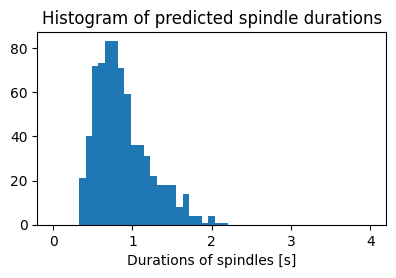

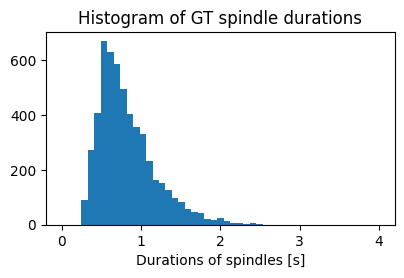

In [5]:
plt.figure(figsize=(4.5, 2.5))
plt.title('Histogram of predicted spindle durations')
plt.hist(pred_sp_df['end'] - pred_sp_df['start'], bins=np.linspace(0, 4, 50))
plt.xlabel('Durations of spindles [s]')
plt.show()

plt.figure(figsize=(4.5, 2.5))
plt.title('Histogram of GT spindle durations')
plt.hist(gt_sp_df['end'] - gt_sp_df['start'], bins=np.linspace(0, 4, 50))
plt.xlabel('Durations of spindles [s]')
plt.show()

# compare spindles

In [6]:
f1_scores = {ovt: {} for ovt in overlap_thresholds}
precision_scores = {ovt: {} for ovt in overlap_thresholds}
recall_scores = {ovt: {} for ovt in overlap_thresholds}

total_tp = {ovt: 0 for ovt in overlap_thresholds}
total_fp = {ovt: 0 for ovt in overlap_thresholds}
total_fn = {ovt: 0 for ovt in overlap_thresholds}
for s_id in test_s_ids:
    tp, fp, fn = [0] * len(overlap_thresholds), [0] * len(overlap_thresholds), [0] * len(overlap_thresholds)

    for block_num in gt_sp_df.query(f'patient_id == "{s_id}"')['block_num'].unique():
        gt_sp = gt_sp_df.query(f'patient_id == "{s_id}" and block_num == {block_num}')[['start', 'end']].values
        # gt_sp = merge_and_filter_spindles(gt_sp)
        pred_sp = pred_sp_df.query(f'patient_id == "{s_id}" and block_num == {block_num}')[['start', 'end']].values
        if len(pred_sp) > 0:
            pred_sp = merge_and_filter_spindles(pred_sp)

        tp_i, fp_i, fn_i = calc_tp_fp_fn(gt_sp, pred_sp, overlap_thresholds)
        tp = [tp[i] + tp_i[i] for i in range(len(overlap_thresholds))]
        fp = [fp[i] + fp_i[i] for i in range(len(overlap_thresholds))]
        fn = [fn[i] + fn_i[i] for i in range(len(overlap_thresholds))]

    for i, ov_thresh in enumerate(overlap_thresholds):
        total_tp[ov_thresh] += tp[i]
        total_fp[ov_thresh] += fp[i]
        total_fn[ov_thresh] += fn[i]

        prec = tp[i] / (tp[i] + fp[i]) if tp[i] + fp[i] > 0 else 1
        rec = tp[i] / (tp[i] + fn[i]) if tp[i] + fn[i] > 0 else 1
        f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
        print(
            f'File {s_id}, overlap threshold: {ov_thresh}, '
            f'#spindles pred: {tp[i] + fp[i]}, #spindles gt: {tp[i] + fn[i]}, '
            f'prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')
        f1_scores[ov_thresh][s_id] = f1
        precision_scores[ov_thresh][s_id] = prec
        recall_scores[ov_thresh][s_id] = rec

Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
File 01-05-0024, overlap threshold: 0.1, #spindles pred: 14, #spindles gt: 15.0, prec: 0.857, rec: 0.800, f1: 0.828
File 01-05-0024, overlap threshold: 0.2, #spindles pred: 14, #spindles gt: 15.0, prec: 0.857, rec: 0.800, f1: 0.828
File 01-05-0024, overlap threshold: 0.5, #spindles pred: 14, #spindles gt: 15.0, prec: 0.786, rec: 0.733, f1: 0.759
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
File 01-05-0020, overlap threshold: 0.1, #spindles pred: 61, #spindles gt: 48.0, prec: 0.754, rec: 0.958, f1: 0.844
File 01-05-0020, overlap threshold: 0.2, #spindles pred: 61, #spindles gt: 48.0, prec: 0.754, rec: 0.958, f1: 0.844
File 01-05-0020, overlap threshold: 0.5, #spindles pred: 61, #spindles gt: 48.0, prec: 0.721, rec: 0.917, f1: 0.807
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 s

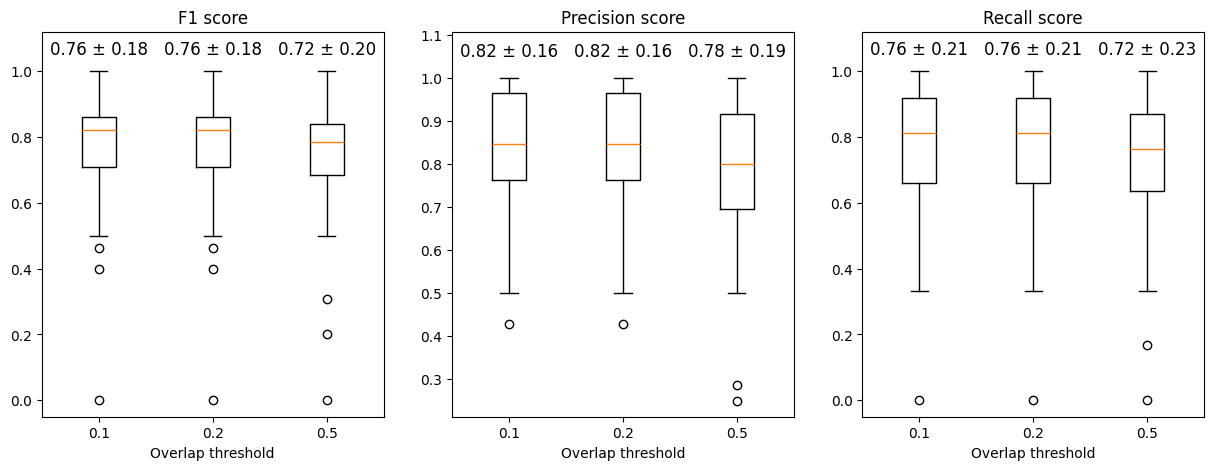

Expert centered scores:
Overlap threshold: 0.1, prec: 0.838, rec: 0.832, f1: 0.835
Overlap threshold: 0.2, prec: 0.838, rec: 0.832, f1: 0.835
Overlap threshold: 0.5, prec: 0.794, rec: 0.791, f1: 0.792


In [7]:
# plot f1 scores as boxplot
def plot_scores(f1_scores, precision_scores, recall_scores):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    f1_scores_to_plot = [np.array(list(f1_scores[k].values())) for k in f1_scores.keys()]
    bps = plt.boxplot(f1_scores_to_plot)
    for i in range(len(f1_scores.keys())):
        plt.text(i + 1, bps["whiskers"][2 * i + 1].get_ydata()[1] + 0.05,
                 f"{f1_scores_to_plot[i].mean():.2f} ± {f1_scores_to_plot[i].std():.2f}", size=12, ha="center")
    plt.xticks(range(1, len(f1_scores.keys()) + 1), f1_scores.keys())
    plt.xlabel('Overlap threshold')
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.07)
    plt.title('F1 score')

    plt.subplot(1, 3, 2)
    precision_scores_to_plot = [np.array(list(precision_scores[k].values())) for k in
                                precision_scores.keys()]
    bps = plt.boxplot(precision_scores_to_plot)
    for i in range(len(precision_scores.keys())):
        plt.text(i + 1, bps["whiskers"][2 * i + 1].get_ydata()[1] + 0.05,
                 f"{precision_scores_to_plot[i].mean():.2f} ± {precision_scores_to_plot[i].std():.2f}", size=12,
                 ha="center")
    plt.xticks(range(1, len(precision_scores.keys()) + 1), precision_scores.keys())
    plt.xlabel('Overlap threshold')
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.07)
    plt.title('Precision score')

    plt.subplot(1, 3, 3)
    recall_scores_to_plot = [np.array(list(recall_scores[k].values())) for k in recall_scores.keys()]
    bps = plt.boxplot(recall_scores_to_plot)
    for i in range(len(recall_scores.keys())):
        plt.text(i + 1, bps["whiskers"][2 * i + 1].get_ydata()[1] + 0.05,
                 f"{recall_scores_to_plot[i].mean():.2f} ± {recall_scores_to_plot[i].std():.2f}", size=12, ha="center")
    plt.xticks(range(1, len(recall_scores.keys()) + 1), recall_scores.keys())
    plt.xlabel('Overlap threshold')
    plt.title('Recall score')
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.07)
    plt.show()


plot_scores(f1_scores, precision_scores, recall_scores)

print('Expert centered scores:')
for i, ov_thresh in enumerate(overlap_thresholds):
    prec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fp[ov_thresh]) if total_tp[ov_thresh] + total_fp[
        ov_thresh] > 0 else 1
    rec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fn[ov_thresh]) if total_tp[ov_thresh] + total_fn[
        ov_thresh] > 0 else 1
    f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
    print(f'Overlap threshold: {ov_thresh}, prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')

# spindle metrics

In [8]:
ovt = 0.2
spm_per_block_gt = []
spm_per_block_pred = []

for s_id in test_s_ids:
    for block_num in gt_sp_df.query(f'patient_id == "{s_id}"')['block_num'].unique():
        gt_sp = gt_sp_df.query(f'patient_id == "{s_id}" and block_num == {block_num}')[['start', 'end']].values
        pred_sp = pred_sp_df.query(f'patient_id == "{s_id}" and block_num == {block_num}')[['start', 'end']].values
        if len(pred_sp) > 0:
            pred_sp = merge_and_filter_spindles(pred_sp)

        spm_per_block_gt.append(len(gt_sp) / 115 * 60)
        spm_per_block_pred.append(len(pred_sp) / 115 * 60)

print(f'GT spm: {np.mean(spm_per_block_gt):.2f} ± {np.std(spm_per_block_gt):.2f}')
print(f'Pred spm: {np.mean(spm_per_block_pred):.2f} ± {np.std(spm_per_block_pred):.2f}')

Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filter